<div class="alert alert-info">
nice 10/10

## Attributions

**Naveen:** Reviewed solution

**Emily:** Reviewed solution

**Chris:** Bulk of question

Loading BokehJS ...


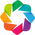

In [1]:
# Imports

import numpy as np
import pandas as pd

import bokeh.io
import bokeh.plotting

import holoviews as hv

import pymc3 as pm
import theano.tensor as tt
import theano

import bebi103

import scipy

import statsmodels.tools.numdiff as smnd

from IPython.display import display # Compatibility fix

bokeh.io.output_notebook()
hv.extension('bokeh')

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

Let's start by reading in the dataframe and establishing the model to calculate expected values to use in sampling. 

We will use uniform prior for $V_0$ since we don't know much about the initial value, and Jeffreys for scaling parameters $c, \delta, \sigma$, like in homework 4.2.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...
Average Loss = 1,395:   8%|▊         | 15198/200000 [00:16<03:33, 863.89it/s]     
Convergence archived at 15200
INFO:pymc3.variational.inference:Convergence archived at 15200
Interrupted at 15,199 [7%]: Average Loss = 7.0582e+06
INFO:pymc3.variational.inference:Interrupted at 15,199 [7%]: Average Loss = 7.0582e+06
100%|██████████| 20000/20000 [05:09<00:00, 64.56it/s] 


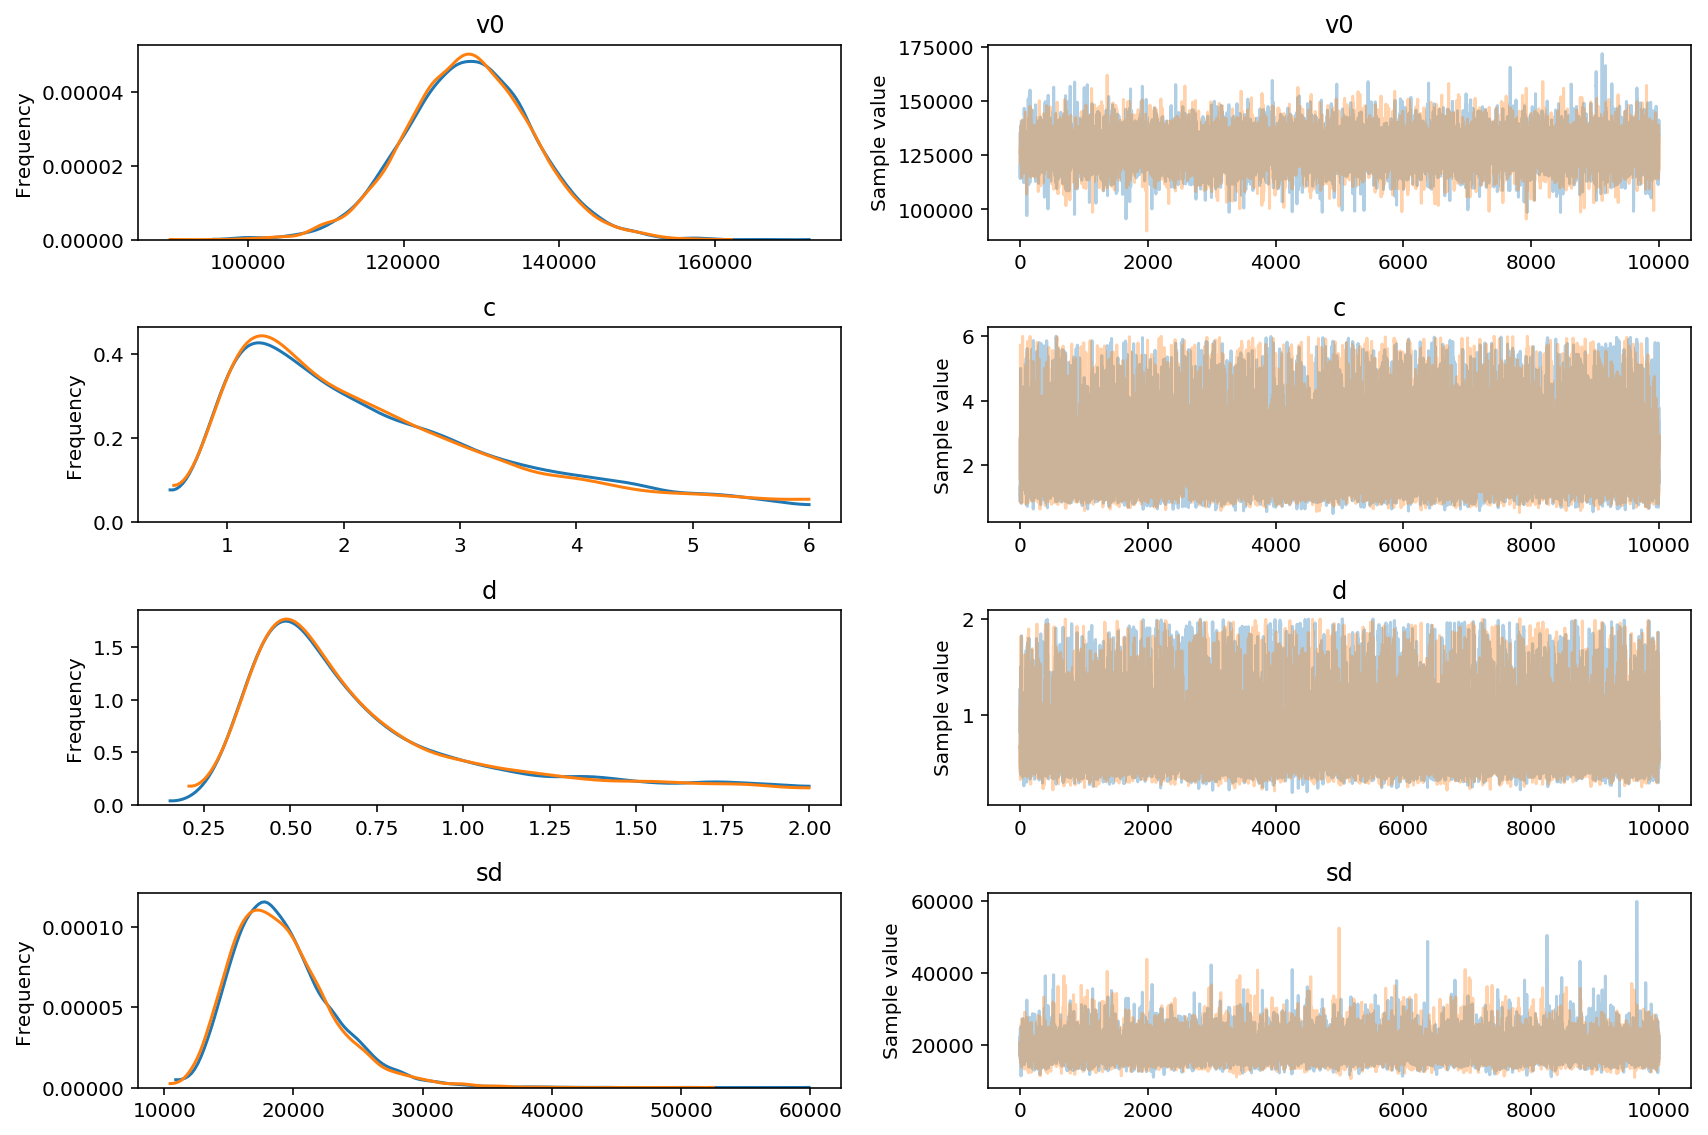

In [2]:
# Load dataframe
df = pd.read_csv('../data/hiv_data.csv', comment='#')

time, vt = df.as_matrix().T

# Expected value based on time and parameters
def expected(c, d, v0, t):
    return tt.switch(tt.eq(d, c),
                     # Limit where c==d
                     (v0 * tt.exp(-d * t) + d * tt.exp(-d * t) * t *v0 + d * d * tt.exp(-d * t) * t * t * v0/2),
                     # Normal expression
                     ( v0 * tt.exp(-c * t) + (c * v0) / (c - d) *
                     (c / (c - d) * (tt.exp(-d * t) - tt.exp(-c * t)) -
                      d * t * tt.exp(-c * t) ) ) )

with pm.Model() as norm_model:
    # Priors
    v0 = pm.Uniform('v0', lower=0, upper=3e5)
    c = bebi103.pm.Jeffreys('c', lower=1/60, upper=6)
    d = bebi103.pm.Jeffreys('d', lower=1/60, upper=2)
    sd = bebi103.pm.Jeffreys('sd', lower=1/60, upper=1e5)
    
    # Calculate theoretical value of vt
    vt_theor = expected(c,d,v0,time)
    
    # Likelihood, assume error=0
    n_obs = pm.Normal('n_obs', mu=vt_theor, sd=sd, observed=vt)
    # My windows machine can't handle more than 1 or 2 jobs
    trace = pm.sample(init='advi+adapt_diag', draws=10000, tune=10000, njobs=2) 
    
    # Show plot of traces
    pm.traceplot(trace)
    
    df_mcmc = bebi103.pm.trace_to_dataframe(trace, log_post = True)

<div class="alert alert-info">
Please explain and comment your code. How did you choose the bounds for your priors? 
<br>Also, because of numerical precision, it is generally not a good idea to compare floats for equality (``tt.eq(d, c)``). Instead, you should check if the absolute difference is greater than some threshold. 

We ran two chains in parallel to confirm stationarity, which we visualized above in the trace plots but can also quantify with the Gelman-Rubin statistic. We want it to be as close to 1 as possible.

In [3]:
# Checking stationarity
pm.gelman_rubin(trace)

{'c': 0.99996247397829241,
 'd': 1.0000064647795892,
 'sd': 1.000064151556314,
 'v0': 1.0000185124367931}

Cool, they're all very close to 1. We can proceed.

We see from the trace plots that our model has consistent and well-distributed sampling for $c, d,$ and $V_0$, and we get similar values as with the MAP. We can print these values below to be sure instead of just eyeballing the traces.

In [4]:
# Get the index of the most probable parameter set
max_ind = df_mcmc['log_posterior'].idxmax()

# Pull out values.
c_MAP, d_MAP = df_mcmc.loc[max_ind, ['c', 'd']]

# Print the results of c, d
print("""
Most probable parameter values:
c: {0:.3f}
d: {1:.3f}""".format(c_MAP, d_MAP))


Most probable parameter values:
c: 2.338
d: 0.558


Nice! Pymc3 did its job. The rate of clearance, $c$, and also the rate of cell death $\delta$, are very similar to what we got in Problem 4.2.

Now we can also plot the contour plot in the $c-d$ plane as well as the marginalized posterior for c using a corner plot to visualize the data and compare it to the contour plot in Problem 4.2.

In [5]:
# Plot corner plot
g = bebi103.viz.corner(df_mcmc, vars=['c', 'd'])
bokeh.io.show(g)

We can see here that the contour plot in the corner is consistent with the one that we got in problem 4.2b when we marginalized out $V_0$, taking on the "boomerang" shape. This is good; it confirms that Pymc3 sampling method worked for our model.